### Statistické testování


* co je to nulová a alternativní hypotéza
* oboustranná alternativní hypotéza
* pravo/levostranná alternativní hypotéza
* testovací statistika
* standardní chyba testovací statistiky
* postup při realizaci testu: 1. zvolení testu, $H_0$, $H_1$, testovací statistika, výsledek
* t-rozdělení
* jednovýběrový z-test pro průměr
* jednovýběrový t-test pro průměr
* p-hodnota
* chyba I. a II. druhu, 
* spolehlivost/významnost/síla testu

nakreslit rozlozeni nulove hypotezy


Statistické testování zahrnuje soubor různých testů podle probému, který se snažíme vyřešit a podle proměnné, kterou používáme. My si v tomto cvičení na příkladu jednovýběrového z-testu pro průměr ukážeme principy statistického testování, které platí i pro další typy statistických testů. Každý statistický test má 4 fáze:

1. zvolení testu podle výzkumné otázky a typu dat, 
2. formulace nulové $H_0$ a alternativní $H_1$ hypotézy, 
3. výpočet testovací statistiky
4. interpretace výsledku

#### 1. Zvolení testu

Pro toto cvičení budeme používat jednovýběrový z-test pro průměr. Tedy, budeme testovat hodnotu průměru jednoho výběru. Bude nás zajímat průměrná doba, kterou dospělí jedinci v České republice stráví denně na internetu (v minutách). Následující data pocházejíz Europeas Social Study, která byla provedena v roce 2018 *https://raw.githubusercontent.com/schubertjan/cuni/master/stats/data/int_use.csv*. První sloupec obsahuje id respondenta a druhý počet minut kolik strávil denně na internetu. Pojďme se podívat na data.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

int_use = pd.read_csv("https://raw.githubusercontent.com/schubertjan/cuni/master/stats/data/int_use.csv")
print(int_use.head())
#musime se zbavit nejakych chybejicich hodnot
int_use.dropna(inplace=True)
int_use.describe()

   idno  int_use_day_mins
0     2             150.0
1    37              60.0
2    76               NaN
3   131             300.0
4   137               NaN


,idno,int_use_day_mins
count,1605.000000,1605.000000
mean,35782.551402,159.441121
std,20144.938526,115.122129
min,2.000000,3.000000
25%,18052.000000,75.000000
50%,35941.000000,120.000000
75%,53216.000000,210.000000
max,69939.000000,570.000000


#### 2. Formulace nulové a alternativní hypotézy

V této fázi formulujeme nulovou a alternativní hypotézu na základě naší výzkumné otázky. Tyto hypotézy formulujeme **vždy před výpočtem testovací statistiky**. Technicky nám nic nebrání počítat různé testovací statistiky a poté vybrat tu, která vychází zajímavě, ale tímto způsobem se rychle dostaneme do nebezpečné situace. Statistické testy neslouží k objevování vztahů a proto by se tak neměli používat! My si ukážeme 3 různé nulové hypotézy, abychom si ukázali rozdél mezi dvojstranným, levostranným a pravostranným testem. Ve Vašem výzkumu si ale vyberete pouze takovou hypotézu, které odpovídá Vaší výzkumné otázka (a která vychází z vědecké teorie).    


**Dvojstranná hypotéza**

$H_0 = 180 $

$H_1 \neq 180 $


**Levostranná hypotéza**

$H_0 \ge 180$

$H_1 < 180$


**Pravostranná hypotéza** 

$H_0 \le 180$

$H_1 > 180$

#### 3. Výpočet testovací statistiky

Výpočet testovací statistiky bude záležet na tom, který test zvolíme. Různé testy májí různé testovací statistiky a proto je důležité u zvoleného testu porozumět tomu, jakou testovací statistiku počítáme. Obecně ale platí, že každá testovací statistika se vypočítá jako $testovací.statistika = \frac{bodový.odhad - nulová.hypotéza}{směrodatná.chyba.odhadu}$


V našem případě jednovýběrového z-testu pro průměr je naší testovací statistikou z-skór. Z-skór vypočítáme jako $z = \frac{\overline{x} - \mu_0}{\frac{\sigma}{\sqrt{N}}}$, kde $\overline{x}$ je náš výběrový průměr, $\mu_0$ je hodnota z nulové hypotézy a $\frac{\sigma}{\sqrt{N}}$ je směrodatná chyba odhadu. Výběrový průměr spočítáme snadno a směrodatnou chybu odhadu výběrového průměru známe z centrální limitní věty a intervalů spolehlivosti. Pojďme si tedy ukázat, jak bychom vypočítali testovací statistiku pro naše 3 hypotézy.

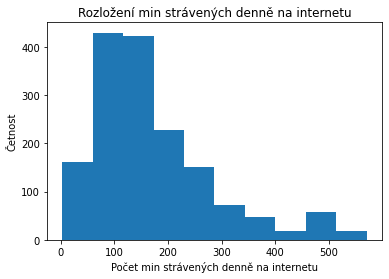

Výběrový průměr: 159.44
Výběrová směrodatná odchylka: 115.12


In [15]:
#podivejme se na vyberovy prumer a smerodatnou odchylku 

plt.hist(int_use.int_use_day_mins)
plt.xlabel("Počet min strávených denně na internetu")
plt.ylabel("Četnost")
plt.title("Rozložení min strávených denně na internetu")
plt.show()

print(f"Výběrový průměr: {int_use.int_use_day_mins.mean().round(2)}")
print(f"Výběrová směrodatná odchylka: {int_use.int_use_day_mins.std().round(2)}")

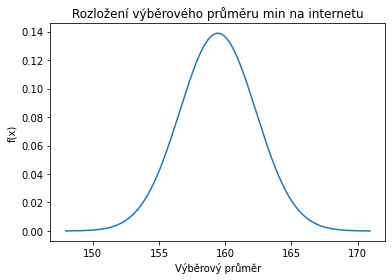

In [31]:
# pojdme si nyni ukázat predpokladane rozlozeni vyberoveho prumeru
prumer = int_use.int_use_day_mins.mean()
smerodatna_chyba = int_use.int_use_day_mins.std() / np.sqrt(int_use.shape[0])
x = np.linspace(prumer - 4*smerodatna_chyba, prumer + 4*smerodatna_chyba, num=10000)
pdf = stats.norm.pdf(x, loc = prumer, scale = smerodatna_chyba)

plt.plot(x, pdf)
plt.xlabel("Výběrový průměr")
plt.ylabel("f(x)")
plt.title(f"Rozložení výběrového průměru min na internetu")
plt.show()

U každého statistického testu si zvolíme nějakou kritickou mez, která je určení hladinou pravděpodobnosti $\alpha$. $\alpha$ nám udává pravděpodobnost, že nesprávně zamítneme nulovou hypotézu. Konvenčně se udává hladina $\alpha = 0.05$, ale my si zvolíme nějakou jinou, například $\alpha=0.11$, abychom si ukázali, že tato hladina je do jisté míry arbitrární a záleží na více věcech (jako je síla testu, typ chyby, kterou chcete akceptovat - I.druhu vs II.druhu). Protože z-skór pochází z normálního standardního rozložení můžeme ho vypočítat pomocí funkcí, které již známe (stejně jako jsme určovali u intervalů spolehlivosti). Kritická mez bude záležet na typu nulové a alternativní hypotézy. Pojďme si je ukázat.

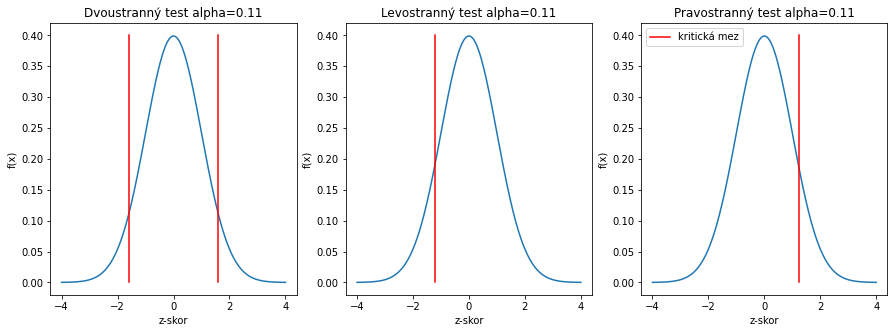

In [50]:
alpha = 0.11
x = np.linspace(-4,4,num=1000)
pdf = stats.norm.pdf(x)

# dvoustranny test
z_d = stats.norm.ppf(alpha/2, loc = 0, scale = 1)
#levostannny
z_l = stats.norm.ppf(alpha, loc = 0, scale = 1)
#pravostranny
z_p = stats.norm.ppf(1-alpha, loc = 0, scale = 1)

fig, ax = plt.subplots(1,3,figsize = (15,5))

ax[0].plot(x, pdf)
ax[0].plot([z_d,z_d],[0,0.40], color = "red", label = "kritická mez")
ax[0].plot([-1*z_d,-1*z_d],[0,0.40], color = "red")
ax[0].set_xlabel("z-skor")
ax[0].set_ylabel("f(x)")
ax[0].set_title(f"Dvoustranný test alpha={alpha}")

ax[1].plot(x, pdf)
ax[1].plot([z_l,z_l],[0,0.40], color = "red", label = "kritická mez")
ax[1].set_xlabel("z-skor")
ax[1].set_ylabel("f(x)")
ax[1].set_title(f"Levostranný test alpha={alpha}")

ax[2].plot(x, pdf)
ax[2].plot([z_p,z_p],[0,0.40], color = "red", label = "kritická mez")
ax[2].set_xlabel("z-skor")
ax[2].set_ylabel("f(x)")
ax[2].set_title(f"Pravostranný test alpha={alpha}")

plt.legend()
plt.show()

In [ ]:
# vypocitat testovaci statistiky
# vypocitat p hodnotu - pravdepodobnost, ze uvidime takovouto hodnotu nebo jeste extremnejsi